<a href="https://colab.research.google.com/github/ronaldexim/dw_matrix_road_sign/blob/master/matrix3_day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import os, datetime
import matplotlib.pyplot as plt
from skimage import color, exposure
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [3]:
cd '/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign/data'

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_three/dw_matrix_road_sign/data


In [0]:
names = pd.read_csv('signnames.csv')
labels_dict = names.to_dict()['b']

In [0]:
train = pd.read_pickle('train.p')
test = pd.read_pickle('test.p')
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [5]:
if y_train.ndim == 1: y_train = to_categorical(y_train)
if y_test.ndim == 1: y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((34799, 43), (4410, 43))

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [0]:
def get_cnn_v1(input_shape, num_classes):
    model = Sequential([
        Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        Flatten(),
        Dense(num_classes, activation='softmax'),
    ])
    return model

def get_cnn_v2(input_shape, num_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        MaxPool2D(),
        Dropout(0.5),

        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),

        Dense(1024, activation='relu'),
        Dropout(0.5),   
        Dense(num_classes, activation='softmax'),
    ])
    return model

def train_model(model, X_train, y_train, params_fit={}):
        model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics='accuracy')

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

        model.fit(
            X_train, 
            y_train,
            batch_size = params_fit.get('batch_size', 128),
            epochs = params_fit.get('epochs', 5),
            verbose = params_fit.get('verbose', 1),
            validation_data = params_fit.get('validation_data', (X_train, y_train)),
            callbacks = [tensorboard_callback]
            )
        return model

In [9]:
params_fit ={
    'epochs': 25
}

model_trained = train_model(get_cnn_v1(input_shape, num_classes), X_train, y_train, params_fit)

Epoch 1/25
272/272 [==============================] - 3s 9ms/step - loss: 37.0506 - accuracy: 0.7372 - val_loss: 0.2123 - val_accuracy: 0.9496
Epoch 2/25
272/272 [==============================] - 2s 9ms/step - loss: 0.1971 - accuracy: 0.9547 - val_loss: 0.0993 - val_accuracy: 0.9772
Epoch 3/25
272/272 [==============================] - 2s 9ms/step - loss: 0.1285 - accuracy: 0.9705 - val_loss: 0.0700 - val_accuracy: 0.9828
Epoch 4/25
272/272 [==============================] - 2s 9ms/step - loss: 0.1132 - accuracy: 0.9745 - val_loss: 0.0703 - val_accuracy: 0.9838
Epoch 5/25
272/272 [==============================] - 2s 9ms/step - loss: 0.0899 - accuracy: 0.9798 - val_loss: 0.0396 - val_accuracy: 0.9909
Epoch 6/25
272/272 [==============================] - 2s 9ms/step - loss: 0.0888 - accuracy: 0.9811 - val_loss: 0.0983 - val_accuracy: 0.9777
Epoch 7/25
272/272 [==============================] - 2s 8ms/step - loss: 0.0833 - accuracy: 0.9808 - val_loss: 0.0573 - val_accuracy: 0.9864
Epoch

In [17]:
y_pred_prob = model_trained.predict(X_test)
y_pred_prob[400]

array([1.5061661e-18, 9.9998879e-01, 7.3409547e-31, 0.0000000e+00,
       1.1175117e-05, 9.1999237e-25, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 2.5063966e-38, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00], dtype=float32)

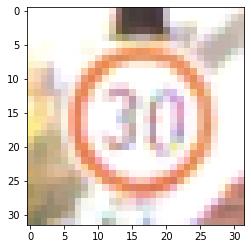

In [16]:
plt.imshow(X_test[400]);

In [21]:
labels_dict[np.argmax(y_pred_prob[400])]

'Speed limit (30km/h)'

<BarContainer object of 43 artists>

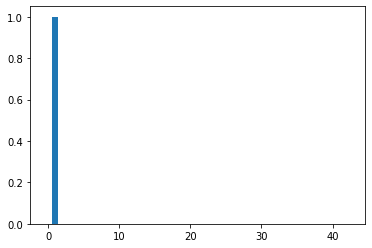

In [22]:
plt.bar(range(43), y_pred_prob[400])

In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):

    y_test_norm = np.argmax(y_test, axis=1)

    y_pred_prob = model_trained.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    return scoring(y_test_norm, y_pred)

In [28]:
predict(model_trained, X_test, y_test)

0.8793650793650793

In [0]:
def train_predict(model):
    model_trained = train_model(model, X_train, y_train, params_fit)
    return predict(model_trained, X_test, y_test)

In [33]:
def get_cnn_v3(input_shape, num_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),

        Dense(1024, activation='relu'),
        Dropout(0.3),   
        Dense(num_classes, activation='softmax'),
    ])
    model.summary()
    return model
train_predict(get_cnn_v3(input_shape, num_classes))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)             

0.9433106575963719

In [35]:
def get_cnn_v4(input_shape, num_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),

        Dense(1024, activation='relu'),
        Dropout(0.3),   
        Dense(num_classes, activation='softmax'),
    ])
    model.summary()
    return model
train_predict(get_cnn_v4(input_shape, num_classes))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 64)         

0.9748299319727891

In [36]:
def get_cnn_v5(input_shape, num_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),

        Dense(1024, activation='relu'),
        Dropout(0.3),   
        Dense(num_classes, activation='softmax'),
    ])
    model.summary()
    return model
train_predict(get_cnn_v5(input_shape, num_classes))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)         

0.9777777777777777

In [37]:
def get_cnn_v6(input_shape, num_classes):
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
        Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
        Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
        MaxPool2D(),
        Dropout(0.3),

        Flatten(),

        Dense(1024, activation='relu'),
        Dropout(0.3),

        Dense(1024, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax'),
    ])
    model.summary()
    return model
train_predict(get_cnn_v6(input_shape, num_classes))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 64)         

0.9682539682539683

In [39]:
color.rgb2gray(X_train[0]).shape

(32, 32)

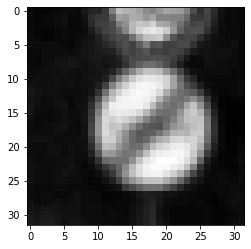

In [43]:
plt.imshow(color.rgb2gray(X_train[0]), cmap=plt.get_cmap('gray'))

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [48]:
model = get_cnn_v5((32, 32, 1), num_classes)
model_trained = train_model(model, X_train_gray, y_train, params_fit)
predict(model_trained, X_test_gray, y_test)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 6, 6, 64)         

0.9879818594104308

In [0]:
def preproc_img(img):
    hsv = color.rgb2hsv(img)
    hsv[:, :, 2] = exposure.equalize_adapthist(hsv[:, :, 2])
    img = color.hsv2rgb(hsv)
    return img

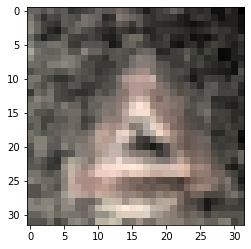

In [51]:
plt.imshow(preproc_img(X_train[400]))

In [54]:
preproc_img(X_train[400]).shape

(32, 32, 3)

In [53]:
X_train_prep = X_train.copy().astype(np.float32)
X_test_prep = X_test.copy().astype(np.float32)

for i in tqdm(range(X_train.shape[0])):
    X_train_prep[i] = preproc_img(X_train[i])

for i in tqdm(range(X_test.shape[0])):
    X_test_prep[i] = preproc_img(X_test[i])

100%|██████████| 4410/4410 [00:43<00:00, 100.74it/s]


In [56]:
model = get_cnn_v6(input_shape, num_classes)
model_trained = train_model(model, X_train_prep, y_train, params_fit)
predict(model_trained, X_test_prep, y_test)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 6, 6, 64)        

0.9789115646258504